In [1]:
import os
import rioxarray as riox
import xarray as xr
from hlsstack.utils.hpc_setup import launch_dask
import seaborn as sns
import numpy as np

In [8]:
# dask cluster location
cluster_loc = 'local'

# path to HLS biomass data
hls_path = '/90daydata/cper_neon_aop/hls_nrt/cper/hls_biomass/cper_hls_bm_{}.nc'
lmf_path = '/90daydata/cper_neon_aop/hls_nrt/cper/lmf_biomass/cper_lmf_bm_{}.nc'

# the range of years to be processed
yrs = range(2000, 2025)
# drop 2012 since it could not be processed by LMF
yrs = [x for x in yrs if x != 2012]

hls_yrs = list(np.arange(2015, 2025))
lmf_yrs = [x for x in np.arange(2000, 2015) if x != 2012]

In [3]:
# setup the dask cluster
if cluster_loc == 'local':
    #os.chdir(wkDIR)
    print('   setting up Local cluster...')
    from dask.distributed import LocalCluster, Client
    import dask
    cluster = LocalCluster(n_workers=32, threads_per_worker=2)
    client = Client(cluster)
    display(client)
elif cluster_loc == 'hpc':
    import psutil
    interface_prefs = [
        'ibp175s0',
        'ibp59s0',
        'enp24s0f0',
        'ens7f0',
        'ibp24s0',
        'ib0'
    ]
    interface = [x for x in interface_prefs if x in list(psutil.net_if_addrs().keys())][0]
    if len(interface) == 0:
        print('ERROR: Preferred interfaces not found on node!')
    else:
        print(interface)
    num_jobs=32
    client = launch_dask(cluster_loc=cluster_loc,
                         num_jobs=num_jobs,
                         mem_gb_per=4.0,
                         partition='atlas', 
                         duration='02:00:00',
                         slurm_opts={'interface': interface},
                         extra_directives=["--account=cper_neon_aop"],
                         wait_timeout=300,
                         debug=False)
    display(client)

   setting up Local cluster...


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 32
Total threads: 64,Total memory: 240.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41291,Workers: 32
Dashboard: http://127.0.0.1:8787/status,Total threads: 64
Started: Just now,Total memory: 240.19 GiB
Comm: tcp://127.0.0.1:46033,Total threads: 2
Dashboard: http://127.0.0.1:36477/status,Memory: 7.51 GiB
Nanny: tcp://127.0.0.1:33245,


In [4]:
from tqdm import tqdm

In [5]:
chunks = {'time': -1, 'y': 20, 'x': 20}

In [9]:
ds_template = xr.open_dataset(hls_path.format(str(2024)))
ds_template = ds_template.rio.write_crs("EPSG:3857").rio.reproject("EPSG:32613")

In [63]:
xr_bm_list = []
for idx, yr in enumerate(tqdm(yrs)):
    # define the file path
    if yr in hls_yrs:
        fpath = hls_path.format(str(yr))
        ds = xr.open_dataset(fpath)
        ds = ds.drop(['spatial_ref'])#.chunk(chunks)
        ds = ds.rio.write_crs("EPSG:3857").rio.reproject("EPSG:32613")
    elif yr in lmf_yrs:
        fpath = lmf_path.format(str(yr))
        ds = xr.open_dataset(fpath)
        ds = ds.drop(['spatial_ref', 'YEAR'])#.chunk(chunks)
        ds = ds.reindex({'y': ds_template.y, 'x': ds_template.x}, method='nearest', tolerance=30)
    #if type(ds) == xr.core.dataarray.DataArray:
    #    ds = ds.to_dataset()
    xr_bm_list.append(ds)

100%|██████████| 24/24 [00:18<00:00,  1.27it/s]


In [107]:
ds_bm = xr.concat(xr_bm_list, dim='time', combine_attrs="drop_conflicts")
#ds_bm = xr.combine_by_coords(xr_bm_list, combine_attrs="drop_conflicts", data_vars=['Biomass'], coords=['x', 'y', 'time'])

In [108]:
ds_bm

<xarray.Dataset>
Dimensions:      (y: 325, x: 325, time: 8707)
Coordinates:
    spatial_ref  int64 0
  * y            (y) float64 4.524e+06 4.524e+06 ... 4.515e+06 4.515e+06
  * x            (x) float64 5.176e+05 5.176e+05 ... 5.273e+05 5.273e+05
  * time         (time) datetime64[ns] 2000-02-24 2000-02-25 ... 2024-12-31
Data variables:
    Biomass      (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan

In [109]:
ds_bm = ds_bm.where(ds_bm > 0)

In [110]:
from datetime import datetime, timedelta

In [116]:
leapyear_mask = ds_bm.time.dt.is_leap_year & (ds_bm.time.dt.dayofyear > 59)#(ds_bm.time.dt.month == 2) & (ds_bm.time.dt.day == 29)

In [119]:
leapyear_mask

<xarray.DataArray (time: 8707)>
array([False, False, False, ...,  True,  True,  True])
Coordinates:
    spatial_ref  int64 0
  * time         (time) datetime64[ns] 2000-02-24 2000-02-25 ... 2024-12-31

In [117]:
day_coords = ds_bm.time.dt.dayofyear

In [122]:
# subtract a day for leap years
day_coords[leapyear_mask] = day_coords[leapyear_mask] - 1

In [123]:
ds_bm_daily = ds_bm.groupby(day_coords).mean()

<AxesSubplot:xlabel='dayofyear'>

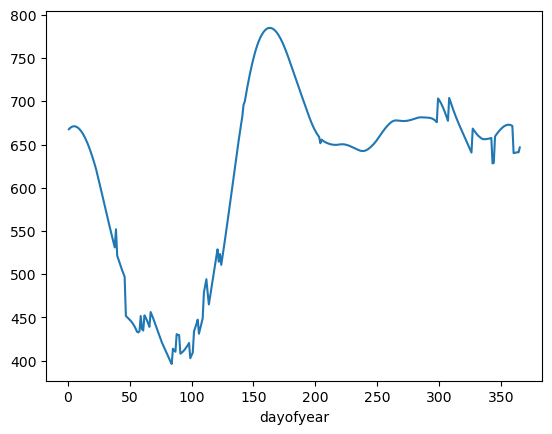

In [124]:
sns.lineplot(y=ds_bm_daily.isel(x=150, y=150)['Biomass'].values, x=ds_bm_daily.dayofyear)

In [132]:
ds_bm_daily.dayofyear//7 + 1

<xarray.DataArray 'dayofyear' (dayofyear: 365)>
array([ 1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
        3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,
        6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,
        8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10,
       10, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 13, 13,
       13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15,
       15, 15, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 18,
       18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20,
       20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 22,
       23, 23, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25,
       25, 25, 25, 25, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 27,
       27, 28, 28, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 29, 29, 30, 30,
       30, 30, 30, 30, 30, 31, 31, 31, 31, 31, 31, 31, 32, 32, 32, 32, 32,
       32, 32, 33, 33, 33, 33, 33, 33, 33, 34, 34, 34, 34, 34, 34, 34, 35,
       35, 35, 35, 35, 35, 35, 36, 36, 36, 36, 36, 36, 36, 37, 37, 37, 37,
       37, 37, 37, 38, 38, 38, 38, 38, 38, 38, 39, 39, 39, 39, 39, 39, 39,
       40, 40, 40, 40, 40, 40, 40, 41, 41, 41, 41, 41, 41, 41, 42, 42, 42,
       42, 42, 42, 42, 43, 43, 43, 43, 43, 43, 43, 44, 44, 44, 44, 44, 44,
       44, 45, 45, 45, 45, 45, 45, 45, 46, 46, 46, 46, 46, 46, 46, 47, 47,
       47, 47, 47, 47, 47, 48, 48, 48, 48, 48, 48, 48, 49, 49, 49, 49, 49,
       49, 49, 50, 50, 50, 50, 50, 50, 50, 51, 51, 51, 51, 51, 51, 51, 52,
       52, 52, 52, 52, 52, 52, 53, 53])
Coordinates:
    spatial_ref  int64 0
  * dayofyear    (dayofyear) int64 1 2 3 4 5 6 7 ... 359 360 361 362 363 364 365

In [134]:
ds_bm_wkly = ds_bm_daily.groupby(ds_bm_daily.dayofyear//7 + 1).mean()

In [138]:
ds_bm_wkly = ds_bm_wkly.rename({'dayofyear': 'week'})

In [139]:
ds_bm_wkly = ds_bm_wkly.sel(week=slice(1, 52))

In [140]:
ds_bm_wkly

<xarray.Dataset>
Dimensions:      (week: 52, y: 325, x: 325)
Coordinates:
    spatial_ref  int64 0
  * y            (y) float64 4.524e+06 4.524e+06 ... 4.515e+06 4.515e+06
  * x            (x) float64 5.176e+05 5.176e+05 ... 5.273e+05 5.273e+05
  * week         (week) int64 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52
Data variables:
    Biomass      (week, y, x) float32 nan nan nan nan ... 1.032e+03 920.3 999.1

<AxesSubplot:xlabel='week'>

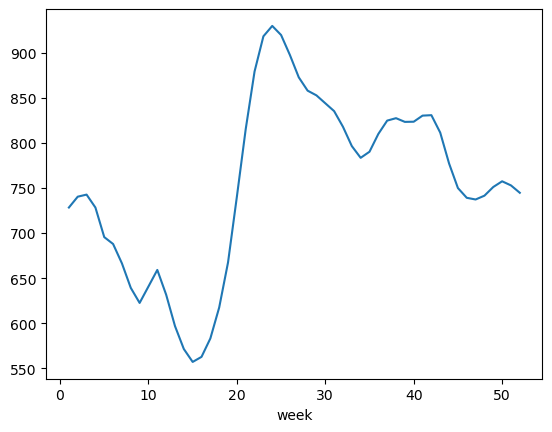

In [144]:
sns.lineplot(y=ds_bm_wkly.isel(x=200, y=200)['Biomass'].values, x=ds_bm_wkly.week)

In [147]:
ds_bm_wkly = ds_bm_wkly.rio.write_transform(ds_template.rio.transform())
ds_bm_wkly = ds_bm_wkly.rio.write_crs(ds_template.rio.crs)

ds_bm_wkly.to_netcdf('/90daydata/cper_neon_aop/hls_nrt/hls_lmf_lta/cper_bm_lta_wkly_2000_2024.nc')
os.chmod('/90daydata/cper_neon_aop/hls_nrt/hls_lmf_lta/cper_bm_lta_wkly_2000_2024.nc', 0o777)

ds_bm_wkly.rio.reproject("EPSG:3857").to_netcdf('/90daydata/cper_neon_aop/hls_nrt/hls_lmf_lta/cper_bm_lta_wkly_2000_2024_gcloud.nc')
os.chmod('/90daydata/cper_neon_aop/hls_nrt/hls_lmf_lta/cper_bm_lta_wkly_2000_2024_gcloud.nc', 0o777)

In [73]:
ds_bm_wkly_hls = ds_bm.where(ds_bm.time.dt.year > 2014).groupby(ds_bm.time.dt.isocalendar().week).mean()

In [74]:
ds_bm_wkly_hls = ds_bm_wkly_hls.sel(week=slice(1, 52))

<AxesSubplot:xlabel='week'>

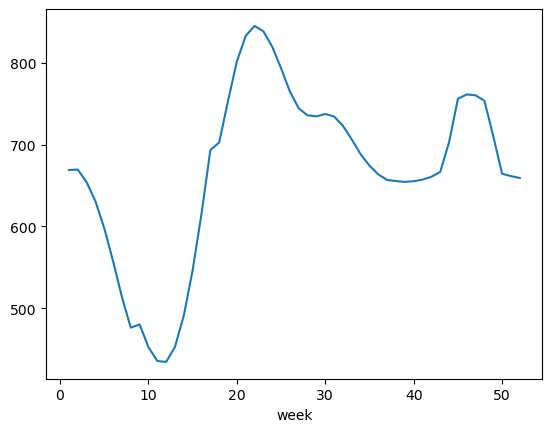

In [75]:
sns.lineplot(y=ds_bm_wkly_hls.isel(x=150, y=150)['Biomass'].values, x=ds_bm_wkly_hls.week)

In [76]:
ds_bm_wkly_lmf = ds_bm.where(ds_bm.time.dt.year <= 2014).groupby(ds_bm.time.dt.isocalendar().week).mean()

In [77]:
ds_bm_wkly_lmf = ds_bm_wkly_lmf.sel(week=slice(1, 52))

<AxesSubplot:xlabel='week'>

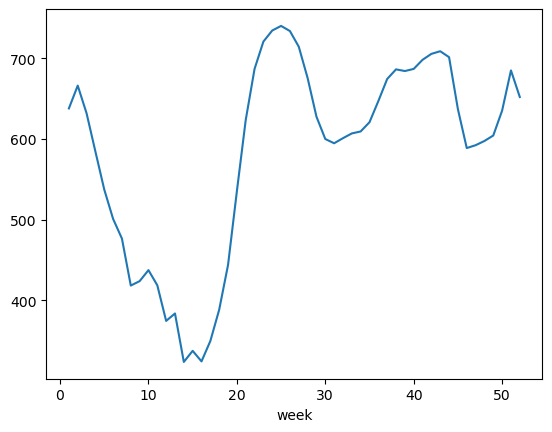

In [78]:
sns.lineplot(y=ds_bm_wkly_lmf.isel(x=150, y=150)['Biomass'].values, x=ds_bm_wkly_lmf.week)

In [45]:
from rasterio.plot import show

In [50]:
fpath = lmf_path.format(str(2010))
ds = xr.open_dataset(fpath)

In [ ]:
ds.reindex({'y': ds_template.y, 'x': ds_template.x}, method='nearest', tolerance=30)

In [58]:
ds_template

<xarray.Dataset>
Dimensions:      (x: 325, y: 325, time: 366)
Coordinates:
  * x            (x) float64 5.176e+05 5.176e+05 ... 5.273e+05 5.273e+05
  * y            (y) float64 4.524e+06 4.524e+06 ... 4.515e+06 4.515e+06
  * time         (time) datetime64[ns] 2024-01-01 2024-01-02 ... 2024-12-31
    spatial_ref  int64 0
Data variables:
    Biomass      (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan

In [59]:
ds = ds.reindex({'y': ds_template.y, 'x': ds_template.x}, method='nearest', tolerance=30)

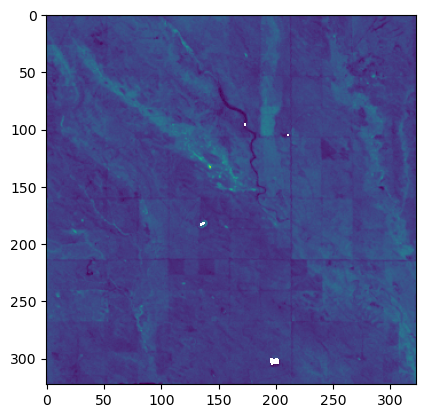

<AxesSubplot:>

In [51]:
show(ds['Biomass'].isel(time=150).data)

KeyError: 'y'

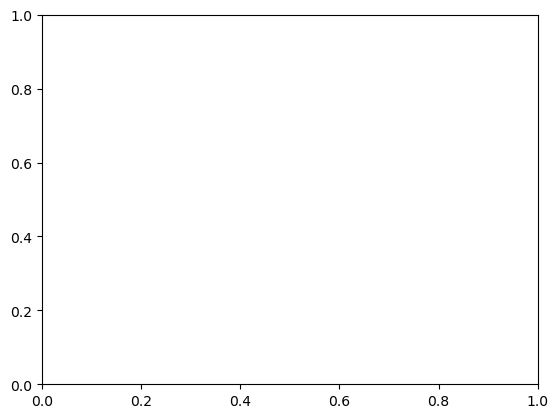